In [81]:
import pandas as pd
from collections import defaultdict

with open('./UCI HAR Dataset/features.txt', 'r', encoding='utf-8') as f:
    headers_raw = [line.strip().split(' ', 1)[1] for line in f]


counter = defaultdict(int)
headers = []

for header in headers_raw:
    counter[header] += 1
    if counter[header] == 1:
        headers.append(header)
    else:
        headers.append(f"{header}_{counter[header]}")

df = pd.read_csv('./samsung_HAR/samsung_train.txt', header=None, names=headers, sep=r'\s+')

df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [82]:
true_labels = pd.read_csv('./samsung_HAR/samsung_train_labels.txt', header=None, index_col=False)
true_labels.head()

,0
0,5
1,5
2,5
3,5
4,5


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


- Czy potrzeba wszystkich cech? Nie, nie potrzeba, tym bardziej, że często są to zmienne zależne, typu średnia z wyników.
- Czy potrzebna jest jakaś obróbka? Redukcja cech, oprócz tego nie występują w zbiorze żadne braki, ani inne anomalie, wymagające obróbki, a dane są znormalizowane, więc te kroki odpadają.
- Czy wiemy, jak obrobić? Redukcja cech np. za pomocą PCA.
- Czy wiemy, co jaka cecha znaczy? Jest opis w pliku, czym są dane cechy
- Czy potrzebujemy aż dwóch plików? Nie, ale można je połączyć żeby mieć więcej danych.
- Pamiętajmy, że mamy do czynienia z Unsupervised Learning. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego? Nie jest potrzebny, bo nie korzystamy z etykiet i nie sprawdzamy wyuczenia modelu w klasyczny sposób, czyli przez sprawdzenie a zbiorze testowym, czy przewidzane etykiety się zgadzają z rzeczywistymi.

In [84]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(df)
print("Liczba kolumn:", pca.n_components_)


Liczba kolumn: 67


In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_data = scaler.fit_transform(pca_data)

In [86]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

kmeans_per_k = [
    KMeans(n_clusters=k, random_state=2).fit(standardized_data)
    for k in range(2, 30)
]

silhouette_scores = [
    silhouette_score(standardized_data, model.labels_)
    for model in kmeans_per_k
]

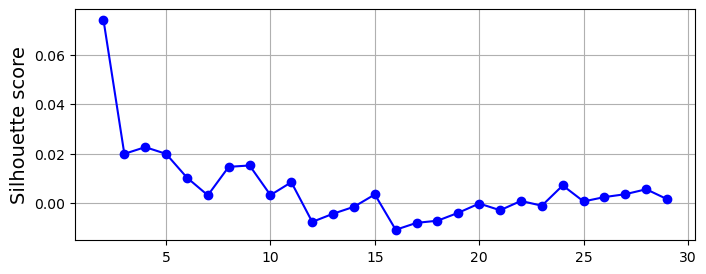

In [87]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(range(2, 30), silhouette_scores, "bo-")
plt.ylabel("Silhouette score", fontsize=14)
plt.grid()
plt.show()

In [88]:
clf_kmeans = KMeans(n_clusters=2)
clf_kmeans.fit(pca_data)

KMeans(n_clusters=2)

In [89]:
import matplotlib.pyplot as plt
import numpy as np

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel2")
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

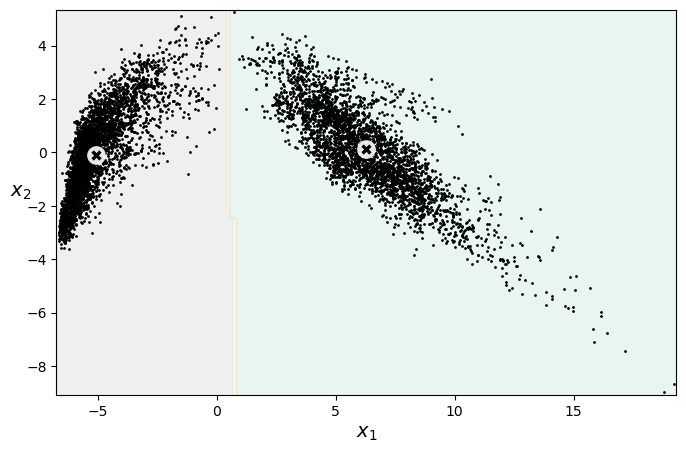

In [90]:
pca_2d = PCA(n_components=2)
standardized_data_2d = pca_2d.fit_transform(df)

clf_kmeans.fit(standardized_data_2d)

plt.figure(figsize=(8, 5))
plot_decision_boundaries(clf_kmeans, standardized_data_2d)
plt.show()

Najlepiej w silhouette_score wypada podział na 2 klastry, więc przeprowadzono taką analizę, jednak wiemy, że klastrów powinno być 6, więc podził z 6 klastrami poniżej.

In [91]:
clf_kmeans = KMeans(n_clusters=6)
predicted_kmeans = clf_kmeans.fit_predict(standardized_data)

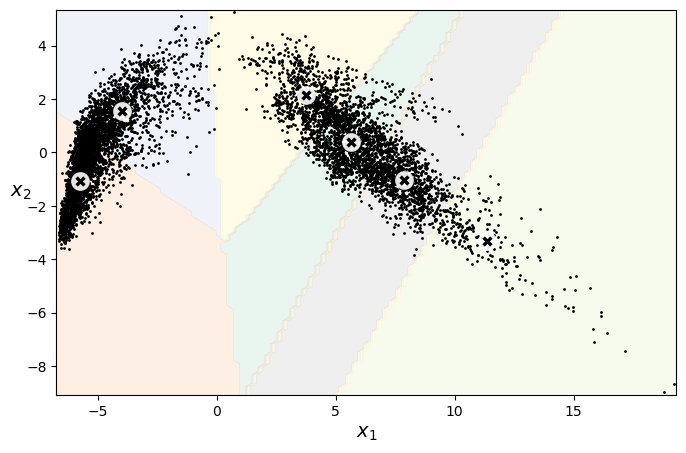

In [92]:
clf_kmeans.fit(standardized_data_2d)

plt.figure(figsize=(8, 5))
plot_decision_boundaries(clf_kmeans, standardized_data_2d)
plt.show()

In [93]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=8.5, min_samples=10)
dbscan.fit(standardized_data)

DBSCAN(eps=8.5, min_samples=10)

In [94]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

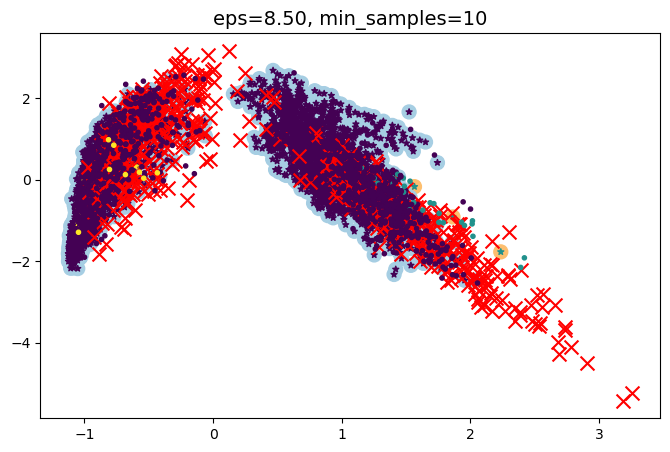

In [95]:
plt.figure(figsize=(8, 5))
plot_dbscan(dbscan, standardized_data, size=100)
plt.show()

In [96]:
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
n_noise = list(dbscan.labels_).count(-1)

print(f"Liczba klastrów: {n_clusters}")
print(f"Liczba punktów szumu: {n_noise}")

Liczba klastrów: 3
Liczba punktów szumu: 561


In [97]:
mask = dbscan.labels_ != -1
filtered_true_labels = true_labels[mask]
filtered_predicted_labels = dbscan.labels_[mask]

In [98]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=6, n_init=10, random_state=42)
gm_predicted = gm.fit_predict(standardized_data)

In [99]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

def plot_gaussian_mixture(clf, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clf.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=3, colors='b')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    plt.xlabel("$x_1$", fontsize=14)
    plt.tick_params(labelleft=False)

In [100]:
gm.fit(standardized_data_2d)

GaussianMixture(n_components=6, n_init=10, random_state=42)

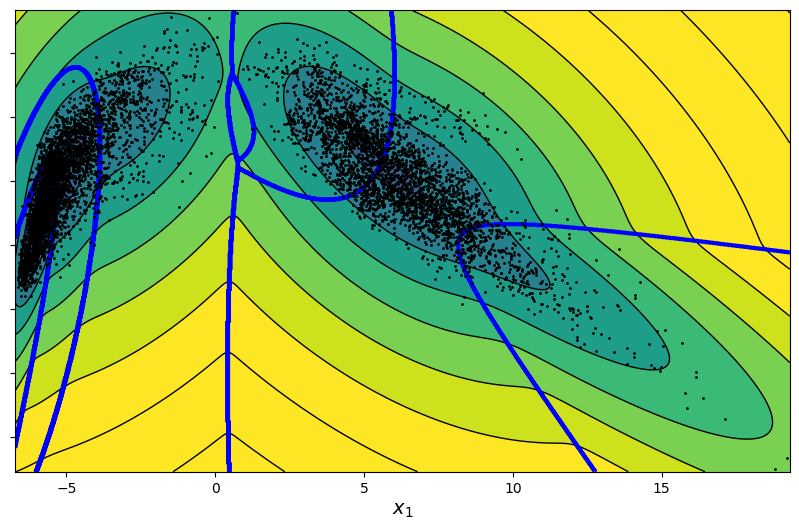

In [101]:

plt.figure(figsize=(10, 6))
plot_gaussian_mixture(gm, standardized_data_2d)
plt.show()

In [102]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import classification_report

def match_labels(true_labels, pred_labels):
    conf_mat = confusion_matrix(true_labels, pred_labels)
    cost_matrix = -conf_mat
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    new_pred = [mapping.get(label, -1) for label in pred_labels]  
    return new_pred, mapping

In [103]:
matched_pred, cluster_to_class = match_labels(true_labels, predicted_kmeans)

print(classification_report(true_labels, matched_pred))

              precision    recall  f1-score   support

           1       0.69      0.59      0.64      1226
           2       0.57      0.73      0.64      1073
           3       0.97      0.89      0.93       986
           4       0.36      0.29      0.32      1286
           5       0.54      0.80      0.65      1374
           6       0.99      0.70      0.82      1407

    accuracy                           0.66      7352
   macro avg       0.69      0.66      0.66      7352
weighted avg       0.68      0.66      0.66      7352



In [104]:
matched_pred, cluster_to_class = match_labels(true_labels, gm_predicted)

print(classification_report(true_labels, matched_pred))

              precision    recall  f1-score   support

           1       0.50      0.32      0.39      1226
           2       0.34      0.62      0.44      1073
           3       0.59      0.32      0.42       986
           4       0.36      0.27      0.31      1286
           5       0.53      0.77      0.63      1374
           6       0.99      0.78      0.87      1407

    accuracy                           0.53      7352
   macro avg       0.55      0.51      0.51      7352
weighted avg       0.56      0.53      0.52      7352



In [105]:
matched_pred, cluster_to_class = match_labels(filtered_true_labels, filtered_predicted_labels)

print(classification_report(filtered_true_labels, matched_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1214
           2       0.00      0.00      0.00      1054
           3       1.00      0.04      0.08       773
           4       0.00      0.00      0.00      1199
           5       0.19      1.00      0.32      1306
           6       1.00      0.02      0.04      1245

    accuracy                           0.20      6791
   macro avg       0.37      0.18      0.07      6791
weighted avg       0.33      0.20      0.08      6791



c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metody KMeans oraz GaussianMixture bardzo dobrze sobie poradziły z wykryciem 6. czynności, czyli leżenia, stosunkowo dobrze wyszło również stanie. KMeans największy problem miało z siedzeniem, ale w tym przypadku najlepiej zostao rozpoznane schodzenie po schodach. GM największy problem miało z siedzeniem, a także z chodzeniem. Jeżeli chodzi o DBSCAN, to cięzko dobrać parametry, tak żeby rozdział był jakkolwiek dobry. Jeżeli ilość klastrów się zwiększa, nie przekłada się to na faktyczne odwzorowanie w prawdziwych danych, więc pozostawiono podział na 3 klastry, które udało się wyodrębnić i są to czynności: stanie, a także w bardzo niewielkim poprawnym odsetku schodzenie po schodach i leżenie.

In [110]:
X_test = pd.read_csv('./samsung_HAR/samsung_test.txt', header=None, names=headers, sep=r'\s+')
y_test = pd.read_csv('./samsung_HAR/samsung_test_labels.txt', header=None, index_col=False)

df_all = pd.concat([df, X_test], axis=0, ignore_index=True)
y_all = pd.concat([true_labels, y_test], axis=0, ignore_index=True)
y_all = y_all.to_numpy().ravel()

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

pipeline = Pipeline([
    ("kmeans", clf_kmeans),
    ("log_reg", LogisticRegression(
        max_iter=5000,
        random_state=2
    )),
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X=df_all, y=y_all, cv=cv, scoring='accuracy')
print(scores.mean())

0.7752219712651538


In [112]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("kmeans", clf_kmeans),
    ("randomForest", RandomForestClassifier(
        n_estimators=100,
        random_state=2
    )),
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X=df_all, y=y_all, cv=cv, scoring='accuracy')
print(scores.mean())

0.7844455551521381


Czym różni się KMeans, K-fold i K Nearest Neighbors
KMeans to algorytm uczenia nienadzorowanego, w którym dane dzielone są na klastry w zależności od ich odległości względem siebie.
K-fold to metda walidacji krzyżowej danych, dzielenie na k-części zbioru, tak, że jedna część to zbiór testowy, pozostałe treningowy i zamiana tyle razy ile jest zbiorów, nastpnie trenowanie na każdym podziale osobno i wyciągnięcie wniosków o całości na koniec.
K Nearest Neighbors to algorytm uczenia nadzorowanego, zarówno regresji jak i klasyfikacji. Działa na zasadzie porównania do k najbliższych sąsiadów i przypisuje wartość na zasadzie podobieństwa do większości.